In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)


# Lecture 13 - Text Features

## DSC 80, Fall 2022

### Today, in DSC 80

- *Quantifying* text data.
- Bag of words.
- Tf-Idf

Remember to refer to [dsc80.com/resources/#regular-expressions](https://dsc80.com/resources/#regular-expressions).

In [1]:
import re
import pandas as pd
import numpy as np

import util

## Text features

### Recall from DSC 40A...

- **Regression** to predict a data scientist's salary
- Collect GPA, years of experience, years of education
- Prediction, after **learning** $w_1, \ldots, w_3$:
$$
\text{salary}
=
w_0
+
w_1 \times (\text{GPA})
+
w_2 \times (\text{experience})
+
w_3 \times (\text{education})
$$

### Features

- GPA, years of experience, and years of education are **features**
- Together, represent a data scientist as a vector of *numbers*
    - A "feature vector"
- Our approach to regression required that these features were numerical

### Now...

- Consider: predict the **sentiment** of a piece of text from 1 to 10.
    - 10: Very positive (happy)
    - 1: Very negative (sad, angry)

Example:

> DSC 80 is a pretty good class.

Predicted sentiment: 7

### Prediction with text

- This can be viewed as a regression problem. Can we use what we learned in 40A?
- Remember: the input had to be *numerical*.
- **Problem**: our input is *text*.

### Text features

- **How do we represent a text document as a feature vector of numbers?**
- If we can do this, we can:
    - use a text document as input in a regression or classification model
    - **quantify** the similarity of two text documents.

### Example: San Diego employee salaries

Recall, in Lectures 1 and 2, we worked with a dataset of San Diego city employee salaries in 2020.

In [2]:
# 2021 data is now actually available, but we will use 2020 data as we did earlier in the quarter
salaries = pd.read_csv('https://transcal.s3.amazonaws.com/public/export/san-diego-2020.csv')
util.anonymize_names(salaries)

In [3]:
salaries.head()

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
0,Michael Xxxx,Police Officer,117691.0,187290.0,13331.00,36380.0,318312.0,NaN,354692.0,2020,NaN,San Diego,FT
1,Gary Xxxx,Police Officer,117691.0,160062.0,42946.00,31795.0,320699.0,NaN,352494.0,2020,NaN,San Diego,FT
2,Eric Xxxx,Fire Engineer,35698.0,204462.0,69121.00,38362.0,309281.0,NaN,347643.0,2020,NaN,San Diego,PT
3,Gregg Xxxx,Retirement Administrator,305000.0,0.0,12814.00,24792.0,317814.0,NaN,342606.0,2020,NaN,San Diego,FT
4,Joseph Xxxx,Fire Battalion Chief,94451.0,157778.0,48151.00,42096.0,300380.0,NaN,342476.0,2020,NaN,San Diego,FT


We asked the question, "Does gender influence pay?"

A followup question to that was "Do men and women make similar salaries amongst those with similar jobs?" – but what makes two jobs similar?

### Exploring job titles

In [4]:
jobtitles = salaries['Job Title']
jobtitles.head()

0              Police Officer
1              Police Officer
2               Fire Engineer
3    Retirement Administrator
4        Fire Battalion Chief
Name: Job Title, dtype: object

How many job titles are there in the dataset? How many **unique** job titles are there?

In [5]:
jobtitles.shape[0], jobtitles.nunique()

(12605, 647)

What are the most common job titles?

In [6]:
jobtitles.value_counts().iloc[:100]

Police Officer           2129
Fire Fighter 2            325
Asst Eng-Civil            279
Grounds Maint Wrkr 2      278
Rec Leader 1              260
                         ... 
Librarian 4                25
Asst Fleet Technician      25
Public Works Supv          25
Custodian 2                25
Asst Deputy Director       25
Name: Job Title, Length: 100, dtype: int64

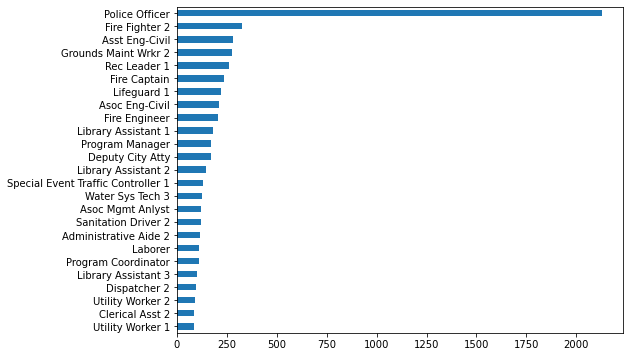

In [7]:
jobtitles.value_counts().iloc[:25].sort_values().plot(kind='barh', figsize=(8, 6));

### Messiness of job titles

- Are there multiple representations of the same job title (e.g. `'Assistant Fire Chief'` vs. `'Asst. Fire Chief'`?
- Are there multiple representations of the same word that is used in multiple job titles (e.g. `'Civil Eng.'` vs `'Mechanical engineer'`)?

Run the cell below repeatedly to get a feel for the "messiness" of job titles in their current state.

In [9]:
jobtitles.sample(10)

42              Police Officer
3552            Police Officer
5736         Jr Engineer-Civil
8173              Equip Tech 1
1223    Structural Engrng Asoc
5124               Librarian 2
3842            Police Officer
9187      Grounds Maint Wrkr 2
6365              Plant Tech 2
7322            Rec Cntr Dir 2
Name: Job Title, dtype: object

### Canonicalizing job titles

Let's try to **canonicalize** job titles. To do this, we'll look at:

- Punctuation.
- "Glue" words.
- Abbreviations.

### Punctuation

Are there job titles with unnecessary punctuation that we can remove? 

- To find out, we can write a regular expression that looks for characters other than letters, numbers, and spaces.

- We can use regular expressions with the `.str` methods we learned earlier in the quarter just by using `regex=True`.

In [10]:
jobtitles.str.contains(r'[^A-Za-z0-9 ]', regex=True).sum()

1133

In [11]:
jobtitles[jobtitles.str.contains(r'[^A-Za-z0-9 ]', regex=True)].head()

67              Fire Captain-Mast
189    Park & Recreation Director
217      Deputy City Atty - Unrep
261             Fire Captain-Mast
283      Deputy City Atty - Unrep
Name: Job Title, dtype: object

It seems like we should replace these pieces of punctuation with a single space.

### "Glue" words

Are there job titles with "glue" words in the middle, such as Assistant <u>to the</u> Chief?

To figure out if any titles contain the word `'to'`, we **can't** just do the following, because it will evaluate to `True` for job titles that have `'to'` anywhere in them, even if not as a standalone word.

In [12]:
# Why are we converting to lowercase?
jobtitles.str.lower().str.contains('to').sum()

833

In [13]:
jobtitles[jobtitles.str.lower().str.contains('to')]

3             Retirement Administrator
22                 Department Director
31       Asst Retirement Administrator
55                  Asst City Attorney
62                 Department Director
                     ...              
12484                    Storekeeper 1
12502            Storm Water Inspctr 3
12504                 Equip Operator 2
12532         Supv Storm Water Inspctr
12552             Sr Customer Srvs Rep
Name: Job Title, Length: 833, dtype: object

Instead, we need to look for `'to'` separated by word boundaries.

In [14]:
jobtitles.str.lower().str.contains(r'\bto\b', regex=True).sum()

11

In [15]:
jobtitles[jobtitles.str.lower().str.contains(r'\bto\b', regex=True)]

723            Principal Asst To City Atty
738                 Asst To The Fire Chief
2087                  Asst To The Director
5221     Conf Secretary To Chief Oper Ofcr
5884                  Asst To The Director
5945        Conf Secretary To Police Chief
6454           Conf Secretary To City Atty
11481              Conf Secretary To Mayor
12061                 Asst To The Director
12120          Conf Secretary To City Atty
12207              Conf Secretary To Mayor
Name: Job Title, dtype: object

We can look for other filler words too, like `'the'` and `'for'`.

In [16]:
jobtitles[jobtitles.str.lower().str.contains(r'\bthe\b', regex=True)]

738      Asst To The Fire Chief
2087       Asst To The Director
5884       Asst To The Director
12061      Asst To The Director
Name: Job Title, dtype: object

In [17]:
jobtitles[jobtitles.str.lower().str.contains(r'\bfor\b', regex=True)]

3352    Asst For Community Outreach
6356    Asst For Community Outreach
Name: Job Title, dtype: object

We should probably remove these "glue" words.

### Fixing punctuation and removing "glue" words

To canonicalize job titles, we'll start by:
- converting to lowercase,
- removing each occurrence of `'to'`, `'the'`, and `'for'`,
- replacing each non-letter/digit/space character with a space, and
- replacing each sequence of multiple spaces with a single space.

In [18]:
jobtitles = (
    jobtitles
    .str.lower()
    .str.replace(r'\bto|\bthe|\bfor', '', regex=True)
    .str.replace('[^A-Za-z0-9 ]', ' ', regex=True)
    .str.replace(' +', ' ', regex=True)               # ' +' matches 1 or more occurrences of a space
    .str.strip()                                      # Removes leading/trailing spaces if present
)

In [19]:
jobtitles.sample(10)

8746                        utility worker 2
4616                  mechanical inspector 2
6419                       grounds maint mgr
11681                    library assistant 1
11279                               rec aide
11737                               rec aide
11888                    rap recreatn leader
8570                  mayor representative 2
3612                   sr water utility supv
12399    equip oper 1 sewer maint equip oper
Name: Job Title, dtype: object

### Abbreviations 

Which job titles are inconsistently described? Let's look at three categories – librarians, engineers, and directors.

In [20]:
jobtitles[jobtitles.str.contains('libr')].value_counts()

library assistant 1      179
library assistant 2      143
library assistant 3      101
librarian 2               66
librarian 3               32
librarian 4               25
supv librarian             7
library technician         7
librarian 1                6
deputy library dir         2
city librarian             1
librarian 3 law librn      1
sr library tech            1
Name: Job Title, dtype: int64

In [21]:
jobtitles[jobtitles.str.contains('eng')].value_counts()

asst eng civil                             279
asoc eng civil                             210
fire engineer                              208
sr civil engineer                           71
jr engineer civil                           70
principal engrng aide                       60
asst eng traffic                            33
asoc eng traffic                            28
structural engrng asoc                      23
student engineer                            20
sr engineering aide                         16
sr traffic engineer                         13
asoc eng electrical                         13
auto messenger 1                             9
structural engrng sr                         9
asst eng civil cntrct spec                   9
asoc eng civil sr cntrct spec                9
auto messenger 2                             8
asst eng electrical                          7
asoc eng fire protection                     5
asoc eng mechanical                          5
asoc commctns

In [22]:
jobtitles[jobtitles.str.contains('dir')].value_counts()

deputy director                    78
asst rec ctr dir                   45
rec cntr dir 3                     30
asst deputy director               25
department director                20
rec cntr dir 2                     14
asst department director           10
executive director                  9
rec cntr dir 1                      9
asst development services dir       3
asst director                       3
deputy library dir                  2
real estate assets dir              2
governmental rel dir                2
deputy pers director                2
risk management director            1
development services dir            1
deputy planning director            1
asst environmental services dir     1
personnel director                  1
planning director                   1
asst planning director              1
environmental services dir          1
asst metro wstwtr dir               1
public utilities director           1
park recreation director            1
asst pers di

### The limits of canonicalization

- Our current approach requires a lot of manual labor.
    - There may be more abbreviations in use amongst job titles (like `'asst'` for `'assistant'`), but how do we find them?
- Remember, our goal is to quantify how similar two job titles are.
- **Idea:** Two job titles are similar if they contain similar words (regardless of order).

In [1]:
import re
import pandas as pd
import numpy as np
from IPython.display import YouTubeVideo, display

## Bag of words 💰

In [2]:
salaries = pd.read_csv('https://transcal.s3.amazonaws.com/public/export/san-diego-2020.csv')
jobtitles = salaries['Job Title']

jobtitles = (
    jobtitles
    .str.lower()
    .str.replace(r'\bto|\bthe|\bfor', '', regex=True)
    .str.replace('[^A-Za-z0-9 ]', ' ', regex=True)
    .str.replace(' +', ' ', regex=True)               
    .str.strip()                                      
)

all_words = jobtitles.str.split().sum()
unique_words = pd.Series(all_words).value_counts()

counts_dict = {}
for word in unique_words.index:
    re_pat = fr'\b{word}\b'
    counts_dict[word] = jobtitles.str.count(re_pat).astype(int).tolist()
    
counts_df = pd.DataFrame(counts_dict).set_index(jobtitles)

### Text similarity

- We can check if two strings, `s1` and `s2` are *exactly* the same by writing `s1 == s2`.
- But how can we check if they are *similar* in *meaning*?
- **Idea**: count the number of words they have in common (regardless of order)

### A counts matrix

Let's create a "counts" matrix, such that:
- there is 1 row per job title,
- there is 1 column per **unique** word that is used in job titles, and
- the value in row `title` and column `word` is the number of occurrences of `word` in `title`.

Such a matrix might look like:

| | senior | lecturer | teaching | professor | assistant | associate |
| --- | --- | --- | --- | --- | --- | --- |
| **senior lecturer** | 1 | 1 | 0 | 0 | 0 | 0 |
| **assistant teaching professor** | 0 | 0 | 1 | 1 | 1 | 0 | 
| **associate professor** | 0 | 0 | 0 | 1 | 0 | 1 |
| **senior assistant to the assistant professor** | 1 | 0 | 0 | 1 | 2 | 0 |

### Creating a counts matrix

First, we need to determine all words that are used across all job titles.

In [3]:
jobtitles.str.split()

0                  [police, officer]
1                  [police, officer]
2                   [fire, engineer]
3        [retirement, administrator]
4           [fire, battalion, chief]
                    ...             
12600             [asst, eng, civil]
12601              [police, officer]
12602                [asst, planner]
12603             [project, ofcr, 1]
12604           [utility, worker, 2]
Name: Job Title, Length: 12605, dtype: object

In [4]:
all_words = jobtitles.str.split().sum()
all_words[:10]

['police',
 'officer',
 'police',
 'officer',
 'fire',
 'engineer',
 'retirement',
 'administrator',
 'fire',
 'battalion']

Next, to determined the columns of our matrix, we need to find a list of all **unique** words used in titles. (We can do this with `np.unique`, but `value_counts` shows us the distribution, which is interesting.)

In [5]:
unique_words = pd.Series(all_words).value_counts()
unique_words.head(10)

2          2438
police     2329
officer    2150
1          1589
fire       1067
asst        721
civil       656
eng         615
3           612
asoc        563
dtype: int64

In [6]:
len(unique_words)

435

For each of the 435 unique words that are used in job titles, we can count the number of occurrences of the word in each job title.
- `'assistant fire chief'` contains the word `'assistant'` once, the word `'fire'` once, and the word `'chief'` once.
- `'assistant managers assistant'` contains the word `'assistant'` twice and the word `'managers'` once.

In [7]:
# Created using a dictionary to avoid a "DataFrame is highly fragmented" warning.
counts_dict = {}
for word in unique_words.index:
    re_pat = fr'\b{word}\b'
    counts_dict[word] = jobtitles.str.count(re_pat).astype(int).tolist()
    
counts_df = pd.DataFrame(counts_dict)

In [8]:
counts_df.head()

,2,police,officer,1,fire,asst,civil,eng,3,asoc,...,motive,metro,sign,stores,sec,law,librn,risk,medical,african
0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`counts_df` has one row for all 12605 job titles (employees), and one column for each unique word that is used in a job title.

In [9]:
counts_df.shape

(12605, 435)

To put into context what the numbers in `counts_df` mean, we can show the actual job title for each row.

In [10]:
counts_df = pd.concat([jobtitles.to_frame(), counts_df], axis=1).set_index('Job Title')
counts_df.head()

,2,police,officer,1,fire,asst,civil,eng,3,asoc,...,motive,metro,sign,stores,sec,law,librn,risk,medical,african
Job Title,,,,,,,,,,,,,,,,,,,,,
police officer,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
police officer,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fire engineer,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
retirement administrator,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fire battalion chief,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The first row tells us that the first job title contains `'police'` once and `'officer'` once. The fifth row tells us that the fifth job title contains `'fire'` once.

### Interpreting the counts matrix

In [11]:
counts_df.head()

,2,police,officer,1,fire,asst,civil,eng,3,asoc,...,motive,metro,sign,stores,sec,law,librn,risk,medical,african
Job Title,,,,,,,,,,,,,,,,,,,,,
police officer,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
police officer,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fire engineer,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
retirement administrator,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fire battalion chief,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The Series below describes the 20 most common words used in job titles, along with the number of times they appeared in all job titles (including repeats). We will call these words "top 20".

In [12]:
counts_df.iloc[:, :20].sum()

2            2438
police       2329
officer      2150
1            1589
fire         1067
asst          721
civil         656
eng           615
3             612
asoc          563
assistant     535
sr            529
supv          501
anlyst        477
tech          454
fighter       449
rec           444
library       433
maint         430
engineer      402
dtype: int64

The Series below describes the **number of top 20 words** used in each job title.

In [13]:
counts_df.iloc[:, :20].sum(axis=1)

Job Title
police officer              2
police officer              2
fire engineer               2
retirement administrator    0
fire battalion chief        1
                           ..
asst eng civil              3
police officer              2
asst planner                1
project ofcr 1              1
utility worker 2            1
Length: 12605, dtype: int64

### Question: What job titles are most similar to `'asst fire chief'`?

- Remember, our idea was to treat two job titles as similar if they contain similar words (regardless of order).
- Now that we have `counts_df`, we have a (row) vector for each job title.
- **How do we measure how similar two vectors are?**

To start, let's compare `'asst fire chief'` to `'fire battalion chief'`.

In [14]:
afc = counts_df.loc['asst fire chief'].iloc[0]
afc

2          0
police     0
officer    0
1          0
fire       1
          ..
law        0
librn      0
risk       0
medical    0
african    0
Name: asst fire chief, Length: 435, dtype: int64

In [15]:
fbc = counts_df.loc['fire battalion chief'].iloc[0]
fbc

2          0
police     0
officer    0
1          0
fire       1
          ..
law        0
librn      0
risk       0
medical    0
african    0
Name: fire battalion chief, Length: 435, dtype: int64

We can stack these two vectors horizontally.

In [16]:
pair_counts = (
    pd.concat([afc, fbc], axis=1)
    .sort_values(by=['asst fire chief', 'fire battalion chief'], ascending=False)
    .head(10)
    .T
)

pair_counts

,fire,chief,asst,battalion,2,police,officer,1,civil,eng
asst fire chief,1,1,1,0,0,0,0,0,0,0
fire battalion chief,1,1,0,1,0,0,0,0,0,0


One way to measure how similar the above two vectors are is through their **dot product**.

In [17]:
np.sum(pair_counts.iloc[0] * pair_counts.iloc[1])

2

Here, since both vectors consist only of 1s and 0s, the dot product is equal to the **number of shared words** between the two job titles.

### Aside: dot product

- Recall, if $\vec{a} = \begin{bmatrix} a_1 & a_2 & ... & a_n \end{bmatrix}^T$ and $\vec{b} = \begin{bmatrix} b_1 & b_2 & ... & b_n \end{bmatrix}^T$ are two vectors, then their **dot product** $\vec{a} \cdot \vec{b}$ is defined as:

$$\vec{a} \cdot \vec{b} = a_1b_1 + a_2b_2 + ... + a_nb_n$$

- The dot product also has a **geometric** interpretation. If $|\vec{a}|$ and $|\vec{b}|$ are the $L_2$ norms (lengths) of $\vec{a}$ and $\vec{b}$, and $\theta$ is the angle between $\vec{a}$ and $\vec{b}$, then:

$$\vec{a} \cdot \vec{b} = |\vec{a}| |\vec{b}| \cos \theta$$

- $\cos \theta$ is equal to its maximum value (1) when $\theta = 0$, i.e. when $\vec{a}$ and $\vec{b}$ point in the same direction. 

- 🚨 **Key idea: The more similar two unit vectors are, the larger their dot product is!**

### Computing similarities

To find the job title that is most similar to `'asst fire chief'`, we can compute the dot product of the `'asst fire chief'` word vector with all other titles' word vectors, and find the title with the highest dot product.

In [18]:
counts_df.head()

,2,police,officer,1,fire,asst,civil,eng,3,asoc,...,motive,metro,sign,stores,sec,law,librn,risk,medical,african
Job Title,,,,,,,,,,,,,,,,,,,,,
police officer,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
police officer,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fire engineer,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
retirement administrator,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fire battalion chief,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
afc

2          0
police     0
officer    0
1          0
fire       1
          ..
law        0
librn      0
risk       0
medical    0
african    0
Name: asst fire chief, Length: 435, dtype: int64

To do so, we can apply `np.dot` to each row that doesn't correspond to `'asst fire chief'`.

In [20]:
dots = (
    counts_df[counts_df.index != 'asst fire chief']
    .apply(lambda s: np.dot(s, afc), axis=1)
    .sort_values(ascending=False)
)

dots

Job Title
asst deputy chief oper ofcr    2
fire battalion chief           2
deputy fire chief              2
fire battalion chief           2
deputy fire chief              2
                              ..
lifeguard 3                    0
water sys tech 3               0
sr commctns tech               0
sr life safety inspector       0
utility worker 2               0
Length: 12601, dtype: int64

The unique job titles that are **most similar** to `'asst fire chief'` are given below.

In [21]:
np.unique(dots.index[dots == dots.max()])

array(['asst chief oper ofcr', 'asst deputy chief oper ofcr',
       'asst fire marshal civ', 'deputy fire chief',
       'fire battalion chief', 'fire chief'], dtype=object)

Note that they all share two words in common with `'asst fire chief'`.

**Note:** To truly use the dot product as a measure of similarity, we should **normalize** by the lengths of the word vectors. More on this soon.

### Bag of words

- The **bag of words** model represents texts (e.g. job titles, sentences, documents) as **vectors of word counts**.
    - The "counts" matrices we have worked with so far were created using the bag of words model.
    - The bag of words model defines a **vector space** in $\mathbb{R}^{\text{number of unique words}}$.
- It is called "bag of words" because it doesn't consider **order**.

<center><img src='imgs/bag-of-words.jpeg' width=45%></center>

<center><a href="https://42f6861cgkip12ijm63i3orf-wpengine.netdna-ssl.com/wp-content/uploads/2020/12/2020-07-bagofwords.jpg">(source)</a></center>

### Cosine similarity and bag of words

To measure the similarity between two word vectors, we compute their dot product, also known as their **cosine similarity**.

$$\cos \theta = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}| | \vec{b}|}$$

If $\cos \theta$ is large, the two word vectors are similar. **It is important to normalize by the lengths of the vectors**, otherwise texts with more words will have artificially high similarities with other texts.

**Note:** Sometimes, you will see the **cosine distance** being used. It is the complement of cosine similarity:
  
  $$\text{dist}(\vec{a}, \vec{b}) = 1 - \cos \theta$$
  
If $\text{dist}(\vec{a}, \vec{b})$ is small, the two word vectors are similar.

### A recipe for computing similarities

Given a set of texts, to find the **most similar** text to one text $T$ in particular:
- Use the bag of words model to create a counts matrix. Specifically:
    - Create an index out of **all** distinct words used across all texts.
    - Create a single vector for each text by counting the number of occurrences of each distinct word.
- Compute the cosine similarity between text $T$ and all other texts.
- The other text with the greatest cosine similarity is the most similar, under the bag of words model.

### Example: Global warming 🌎

Consider the following **sentences**.

In [22]:
sentences = pd.Series([
    'I really want global peace',
    'I must love global warming',
    'We must solve climate change'
])

sentences

0      I really want global peace
1      I must love global warming
2    We must solve climate change
dtype: object

Let's represent each sentence using the bag of words model.

In [23]:
unique_words = pd.Series(sentences.str.split().sum()).value_counts()
unique_words

I          2
global     2
must       2
really     1
want       1
peace      1
love       1
warming    1
We         1
solve      1
climate    1
change     1
dtype: int64

In [24]:
counts_dict = {}
for word in unique_words.index:
    re_pat = fr'\b{word}\b'
    counts_dict[word] = sentences.str.count(re_pat).astype(int).tolist()
    
counts_df = pd.DataFrame(counts_dict).set_index(sentences)

In [25]:
counts_df

,I,global,must,really,want,peace,love,warming,We,solve,climate,change
I really want global peace,1,1,0,1,1,1,0,0,0,0,0,0
I must love global warming,1,1,1,0,0,0,1,1,0,0,0,0
We must solve climate change,0,0,1,0,0,0,0,0,1,1,1,1


Let's now find the cosine similarity between each sentence.

In [26]:
# There is an easier way of doing this in sklearn, as we will see soon
def sim_pair(s1, s2):
    return np.dot(s1, s2) / (np.linalg.norm(s1) * np.linalg.norm(s2))

In [27]:
sim_pair(counts_df.iloc[0], counts_df.iloc[1])

0.3999999999999999

In [28]:
sim_pair(counts_df.iloc[0], counts_df.iloc[2])

0.0

In [29]:
sim_pair(counts_df.iloc[1], counts_df.iloc[2])

0.19999999999999996

**Issue:** Bag of words only encodes the **words** that each sentence uses, not their **meanings**.
- Sentence 0 and sentence 2 have similar meanings, but have no shared words.
- Sentence 0 and sentence 1 have very different meanings, but a relatively high cosine similarity.

### Pitfalls of the bag of words model

Remember, the key assumption underlying the bag of words model is that **two texts are similar if they share many words in common**.

- The bag of words model doesn't consider **order**.
    - The job titles `'asst fire chief'` and `'chief fire asst'` are treated as the same.
- The bag of words model treats all words as being equally important.
    - `'asst'` and `'fire'` have the same importance, even though `'fire'` is probably more important in describing someone's job title.
- The bag of words model doesn't consider the **meaning** of words.
    - `'I love data science'` and `'I hate data science'` share 75% of their words, but have very different meanings.

### Summary

- The bag of words model allows us to turn documents into numerical vectors of word counts.
    - It treats two documents as similar if they share many words in common.
    - It doesn't consider the order, importance, or meaning of words.

In [2]:
import re
import pandas as pd
import numpy as np
from IPython.display import YouTubeVideo, display

In [3]:
salaries = pd.read_csv('https://transcal.s3.amazonaws.com/public/export/san-diego-2020.csv')
jobtitles = salaries['Job Title']

jobtitles = (
    jobtitles
    .str.lower()
    .str.replace(r'\bto|\bthe|\bfor', '', regex=True)
    .str.replace('[^A-Za-z0-9 ]', ' ', regex=True)
    .str.replace(' +', ' ', regex=True)               
    .str.strip()                                      
)

all_words = jobtitles.str.split().sum()
unique_words = pd.Series(all_words).value_counts()

counts_dict = {}
for word in unique_words.index:
    re_pat = fr'\b{word}\b'
    counts_dict[word] = jobtitles.str.count(re_pat).astype(int).tolist()
    
counts_df = pd.DataFrame(counts_dict).set_index(jobtitles)

## TF-IDF 🕶️

### The importance of words

**Issue:** The bag of words model doesn't know which words are "important" in a document. How do we determine which words are important?
- The most common words ("the", "of") often **don't** have much meaning!
- The very rare words are also less important!

**Goal:** Find a way of quantifying the importance of a word in a document by **balancing the above two factors**.
- Put another way: find the word that **best summarizes** a document.

### Term frequency

- The **term frequency** of a word (term) $t$ in a document $d$, denoted $\text{tf}(t, d)$ is the proportion of words in document $d$ that are equal to $t$.

$$\text{tf}(t, d) = \frac{\text{number of occurrences of $t$ in $d$}}{\text{total number of words in $d$}}$$

- **Example:** What is the term frequency of "billy" in the following document?

<center>"my brother has a friend named <b>billy</b> who has an uncle named <b>billy</b>"</center>

- **Answer:** $\frac{2}{13}$.

- Intuition: Words that occur often within a document are important to the document's meaning.
    - If $\text{tf}(t, d)$ is large, then word $t$ occurs often in $d$.
    - If $\text{tf}(t, d)$ is small, then word $t$ does not occur often $d$.
- Issue: "has" also has a TF of $\frac{2}{13}$, but it seems less important than "billy".

### Inverse document frequency

- The **inverse document frequency** of a word $t$ in a set of documents $d_1, d_2, ...$ is

$$\text{idf}(t) = \log \left(\frac{\text{total number of documents}}{\text{number of documents in which $t$ appears}} \right)$$

- **Example:** What is the inverse document frequency of "billy" in the following three documents?
    - "my brother has a friend named **billy** who has an uncle named **billy**"
    - "my favorite artist is named jilly boel"
    - "why does he talk about someone named **billy** so often"

- **Answer:** $\log \left(\frac{3}{2}\right) \approx 0.4055$.

- Intuition: If a word appears in every document (like "the" or "of"), it is probably not a good summary of any one document.
    - If $\text{tdf}(t)$ is large, then $t$ is rarely found in documents.
    - If $\text{tdf}(t)$ is small, then $t$ is commonly found in documents.

### Intuition

$$\text{tf}(t, d) = \frac{\text{number of occurrences of $t$ in $d$}}{\text{total number of words in $d$}}$$

$$\text{idf}(t) = \log \left(\frac{\text{total number of documents}}{\text{number of documents in which $t$ appears}} \right)$$

**Goal:** Quantify how well word $t$ **summarizes** document $d$.

- If $\text{tf}(t, d)$ is small, then $t$ doesn't occur very often in $d$, so $t$ can't be a good summary of $d$.

- If $\text{idf}(t)$ is small, then $t$ occurs often amongst all documents, and so it is not a good summary of any one document.

- If $\text{tf}(t, d)$ and $\text{idf}(t)$ are both large, then **$t$ occurs often in $d$ but rarely overall**.
    - In such a case, $t$ is **a good summary** of document $d$.

### Term frequency-inverse document frequency

The **term frequency-inverse document frequency (TF-IDF)** of word $t$ in document $d$ is the product:

$$
\begin{align*}\text{tfidf}(t, d) &= \text{tf}(t, d) \cdot \text{idf}(t) \\\ &= \frac{\text{number of occurrences of $t$ in $d$}}{\text{total number of words in $d$}} \cdot \log \left(\frac{\text{total number of documents}}{\text{number of documents in which $t$ appears}} \right) \end{align*} $$

- If $\text{tfidf}(t, d)$ is large, then $t$ is a good summary of $d$.
    - But to know if $\text{tfidf}(t, d)$ is large, we need to compare it to $\text{tfidf}(t_i, d)$, for several different words $t_i$.

- TF-IDF is a **heuristic** – it has no probabilistic justification.

### Computing TF-IDF

**Question:** What is the TF-IDF of "global" in the second sentence?

In [15]:
sentences = pd.Series([
    'I really want global peace',
    'I must love global warming',
    'We must solve climate change'
])

sentences

0      I really want global peace
1      I must love global warming
2    We must solve climate change
dtype: object

**Answer**

In [16]:
tf = sentences.iloc[1].count('global') / len(sentences.iloc[1].split())
tf

0.2

In [17]:
idf = np.log(len(sentences) / sentences.str.contains('global').sum())
idf

0.4054651081081644

In [18]:
tf * idf

0.08109302162163289

**Question:** Is this big or small? Is "global" the **best** summary of the second sentence?

### TF-IDF of all words in all documents

On its own, the TF-IDF of a word in a document doesn't really tell us anything; we must compare it to TF-IDFs of other words in that same document.

In [19]:
sentences

0      I really want global peace
1      I must love global warming
2    We must solve climate change
dtype: object

In [20]:
unique_words = np.unique(sentences.str.split().sum())
unique_words

array(['I', 'We', 'change', 'climate', 'global', 'love', 'must', 'peace',
       'really', 'solve', 'want', 'warming'], dtype='<U7')

In [21]:
tfidf_dict = {}

for word in unique_words:
    re_pat = fr'\b{word}\b'
    tf = sentences.str.count(re_pat) / sentences.str.split().str.len()
    idf = np.log(len(sentences) / sentences.str.contains(re_pat).sum())
    tfidf_dict[word] = tf * idf
    
tfidf = pd.DataFrame(tfidf_dict).set_index(sentences)

In [22]:
tfidf

,I,We,change,climate,global,love,must,peace,really,solve,want,warming
I really want global peace,0.081093,0.000000,0.000000,0.000000,0.081093,0.000000,0.000000,0.219722,0.219722,0.000000,0.219722,0.000000
I must love global warming,0.081093,0.000000,0.000000,0.000000,0.081093,0.219722,0.081093,0.000000,0.000000,0.000000,0.000000,0.219722
We must solve climate change,0.000000,0.219722,0.219722,0.219722,0.000000,0.000000,0.081093,0.000000,0.000000,0.219722,0.000000,0.000000


The above DataFrame tells us that:
- the TF-IDF of `'peace'` in the first sentence is 0.219722,
- the TF-IDF of `'climate'` in the second sentence is 0.

Note that there are two ways that $\text{tfidf}(t, d)$ can be 0:
- Word $t$ appears in every document (then $\text{idf}(t) = \log (1) = 0$).
- Word $t$ does not appear in document $d$ (then $\text{tf}(t, d) = \frac{0}{\text{len}(d)} = 0$).

The word that **best summarizes** a document is the word with the highest TF-IDF for that document:

In [23]:
tfidf

,I,We,change,climate,global,love,must,peace,really,solve,want,warming
I really want global peace,0.081093,0.000000,0.000000,0.000000,0.081093,0.000000,0.000000,0.219722,0.219722,0.000000,0.219722,0.000000
I must love global warming,0.081093,0.000000,0.000000,0.000000,0.081093,0.219722,0.081093,0.000000,0.000000,0.000000,0.000000,0.219722
We must solve climate change,0.000000,0.219722,0.219722,0.219722,0.000000,0.000000,0.081093,0.000000,0.000000,0.219722,0.000000,0.000000


In [24]:
tfidf.idxmax(axis=1)

I really want global peace      peace
I must love global warming       love
We must solve climate change       We
dtype: object

Look closely at the rows of `tfidf` – in sentences 0 and 2, the max TF-IDF is not unique!

## Example: State of the Union addresses 🎤

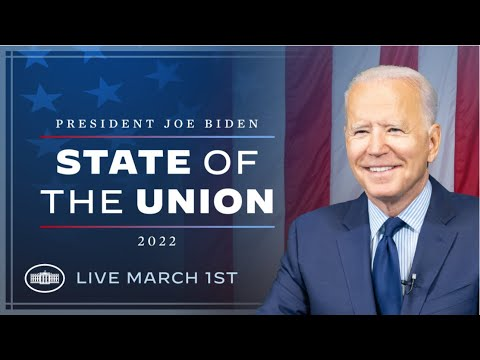

In [25]:
YouTubeVideo('mVIXLQrC9rE')

### The data

In [26]:
sotu = open('data/stateoftheunion1790-2022.txt').read()

In [27]:
len(sotu)

10535675

The entire **corpus** (another word for "set of documents") is over 10 million characters long... let's not display it in our notebook.

In [28]:
print(sotu[:20000])

The Project Gutenberg EBook of Complete State of the Union Addresses,
from 1790 to the Present. Speeches beginning in 2002 are from UCSB The American Presidency Project.
Speeches from 2018-2022 were manually downloaded from whitehouse.gov.

Character set encoding: UTF8

The addresses are separated by three asterisks


CONTENTS

  George Washington, State of the Union Address, January 8, 1790
  George Washington, State of the Union Address, December 8, 1790
  George Washington, State of the Union Address, October 25, 1791
  George Washington, State of the Union Address, November 6, 1792
  George Washington, State of the Union Address, December 3, 1793
  George Washington, State of the Union Address, November 19, 1794
  George Washington, State of the Union Address, December 8, 1795
  George Washington, State of the Union Address, December 7, 1796
  John Adams, State of the Union Address, November 22, 1797
  John Adams, State of the Union Address, December 8, 1798
  John Adams, State of 

Each speech is separated by `'***'`.

In [29]:
speeches = sotu.split('\n***\n')[1:]

In [30]:
len(speeches)

232

Note that each "speech" currently contains other information, like the name of the president and the date of the address.

In [31]:
print(speeches[-1][:1000])


State of the Union Address
Joseph R. Biden Jr.  
March 1, 2022

Madam Speaker, Madam Vice President, and our First Lady and Second Gentleman, members of Congress and the Cabinet, Justices of the Supreme Court, my fellow Americans: Last year, COVID-19 kept us apart. This year, we’re finally together again.

Tonight — tonight we meet as Democrats, Republicans, and independents, but, most importantly, as Americans with a duty to one another, to America, to the American people, and to the Constitution, and an unwavering resolve that freedom will always triumph over tyranny.

Six — thank you. Six days ago, Russia’s Vladimir Putin sought to shake the very foundations of the free world, thinking he could make it bend to his menacing ways. But he badly miscalculated. He thought he could roll into Ukraine and the world would roll over. Instead, he met with a wall of strength he never anticipated or imagined. He met the Ukrainian people.

UKRAINE

From President Zelenskyy to every Ukrainian, th

Let's extract just the speech text.

In [32]:
def extract_struct(speech):
    L = speech.strip().split('\n', maxsplit=3)
    L[3] = re.sub(r"[^A-Za-z' ]", ' ', L[3]).lower()
    return dict(zip(['speech', 'president', 'date', 'contents'], L))

In [33]:
speeches_df = pd.DataFrame(list(map(extract_struct, speeches)))

In [34]:
speeches_df

,speech,president,date,contents
0,State of the Union Address,George Washington,"January 8, 1790",fellow citizens of the senate and house of re...
1,State of the Union Address,George Washington,"December 8, 1790",fellow citizens of the senate and house of re...
2,State of the Union Address,George Washington,"October 25, 1791",fellow citizens of the senate and house of re...
3,State of the Union Address,George Washington,"November 6, 1792",fellow citizens of the senate and house of re...
4,State of the Union Address,George Washington,"December 3, 1793",fellow citizens of the senate and house of re...
...,...,...,...,...
227,State of the Union Address,Donald J. Trump,"January 30, 2018",mr speaker mr vice president members of c...
228,State of the Union Address,Donald J. Trump,"February 5, 2019",madam speaker mr vice president members of...
229,State of the Union Address,Donald J. Trump,"February 4, 2020",thank you very much thank you thank you ver...
230,State of the Union Address,Joseph R. Biden Jr.,"April 28, 2021",thank you thank you thank you good to be b...


### Finding the most important words in each speech

Here, a "document" is a speech. We have 232 documents.

In [35]:
speeches_df.head()

,speech,president,date,contents
0,State of the Union Address,George Washington,"January 8, 1790",fellow citizens of the senate and house of re...
1,State of the Union Address,George Washington,"December 8, 1790",fellow citizens of the senate and house of re...
2,State of the Union Address,George Washington,"October 25, 1791",fellow citizens of the senate and house of re...
3,State of the Union Address,George Washington,"November 6, 1792",fellow citizens of the senate and house of re...
4,State of the Union Address,George Washington,"December 3, 1793",fellow citizens of the senate and house of re...


A rough sketch of what we'll compute:

```
for each word w:
    for each speech d:
        compute tfidf(w, d)
```

In [36]:
unique_words = pd.Series(speeches_df['contents'].str.split().sum()).value_counts()
unique_words

the           146704
of             94207
to             60350
and            60308
in             38073
               ...  
wonderland         1
policed            1
dallying           1
dilly              1
em                 1
Length: 24103, dtype: int64

In [37]:
unique_words = unique_words.iloc[:500].index

tfidf_dict = {}
tf_denom = speeches_df['contents'].str.split().str.len()
for word in unique_words:
    re_pat = fr' {word} ' # Imperfect pattern for speed
    tf = speeches_df['contents'].str.count(re_pat) / tf_denom
    idf = np.log(len(speeches_df) / speeches_df['contents'].str.contains(re_pat).sum())
    tfidf_dict[word] =  tf * idf

In [38]:
tfidf = pd.DataFrame(tfidf_dict)

In [39]:
tfidf.head()

,the,of,to,and,in,a,that,for,be,our,...,submitted,did,increasing,throughout,point,months,set,object,agreement,almost
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000382,0.000000,0.0,0.0,0.000000,0.002031,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000435,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.001051,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000265,0.000000,0.000181,0.000000,0.0,0.0,0.000345,0.000640,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000215,0.0,0.0,0.000000,0.000705,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000212,0.000000,0.000458,0.0,0.0,0.000000,0.000375,0.0,0.0


Note that the TF-IDFs of many common words are all 0!

### Summarizing speeches

By using `idxmax`, we can find the word with the highest TF-IDF in each speech.

In [40]:
summaries = tfidf.idxmax(axis=1)
summaries

0          object
1      convention
2       provision
3       provision
4           ought
          ...    
227       tonight
228       tonight
229       tonight
230          jobs
231       tonight
Length: 232, dtype: object

What if we want to see the 5 words with the highest TF-IDFs, for each speech?

In [41]:
def five_largest(row):
    return list(row.index[row.argsort()][-5:])

In [42]:
keywords = tfidf.apply(five_largest, axis=1)
keywords_df = pd.concat([
    speeches_df['president'],
    speeches_df['date'],
    keywords
], axis=1)

Run the cell below to see every single row of `keywords_df`.

In [43]:
with pd.option_context('display.max_rows', 300):
    display(keywords_df)

,president,date,0
0,George Washington,"January 8, 1790","[proper, your, regard, ought, object]"
1,George Washington,"December 8, 1790","[case, established, object, commerce, convention]"
2,George Washington,"October 25, 1791","[upon, community, lands, proper, provision]"
3,George Washington,"November 6, 1792","[subject, upon, information, proper, provision]"
4,George Washington,"December 3, 1793","[having, vessels, executive, shall, ought]"
5,George Washington,"November 19, 1794","[too, army, let, ought, constitution]"
6,George Washington,"December 8, 1795","[representatives, prevent, object, provision, ..."
7,George Washington,"December 7, 1796","[republic, treaty, britain, ought, object]"
8,John Adams,"November 22, 1797","[spain, british, claims, treaty, vessels]"
9,John Adams,"December 8, 1798","[st, minister, treaty, spain, commerce]"


### Aside: What if we remove the $\log$ from $\text{idf}(t)$?

Let's try it and see what happens.

In [44]:
tfidf_nl_dict = {}
tf_denom = speeches_df['contents'].str.split().str.len()
for word in unique_words:
    re_pat = fr' {word} ' # Imperfect pattern for speed
    tf = speeches_df['contents'].str.count(re_pat) / tf_denom
    idf_nl = len(speeches_df) / speeches_df['contents'].str.contains(re_pat).sum()
    tfidf_nl_dict[word] =  tf * idf_nl

In [45]:
tfidf_nl = pd.DataFrame(tfidf_nl_dict)

In [46]:
tfidf_nl

,the,of,to,and,in,a,that,for,be,our,...,submitted,did,increasing,throughout,point,months,set,object,agreement,almost
0,0.089073,0.063361,0.051423,0.037649,0.018365,0.019284,0.013774,0.006428,0.018365,0.009183,...,0.000000,0.000000,0.001392,0.000000,0.000000,0.000000,0.000000,0.005758,0.000000,0.000000
1,0.086957,0.063435,0.034925,0.032074,0.019244,0.014968,0.012117,0.011404,0.012830,0.012117,...,0.001312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002979,0.000000,0.000000
2,0.105035,0.069010,0.038194,0.031684,0.017795,0.018229,0.013889,0.009549,0.014757,0.002170,...,0.000799,0.000000,0.000658,0.000000,0.000000,0.000000,0.001291,0.001814,0.000000,0.000000
3,0.093212,0.066444,0.042065,0.026769,0.022945,0.015296,0.011472,0.014340,0.013862,0.005258,...,0.000000,0.000000,0.000000,0.000749,0.000000,0.000000,0.000000,0.001998,0.000000,0.000000
4,0.091603,0.067176,0.037659,0.024936,0.013232,0.017303,0.006107,0.011705,0.021883,0.008142,...,0.000000,0.000772,0.000000,0.001595,0.000000,0.000000,0.000000,0.001064,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.040610,0.023646,0.033756,0.041981,0.017992,0.017135,0.011652,0.007882,0.005312,0.017820,...,0.000000,0.000520,0.000000,0.000000,0.000253,0.001343,0.000510,0.000000,0.000000,0.000834
228,0.049582,0.025413,0.029145,0.034654,0.020970,0.017949,0.011374,0.011374,0.004443,0.017416,...,0.000000,0.002156,0.000000,0.000000,0.000263,0.001114,0.000793,0.000000,0.001309,0.002307
229,0.047201,0.023920,0.026631,0.035242,0.018338,0.016425,0.011162,0.010046,0.003987,0.015149,...,0.000000,0.000242,0.000000,0.000250,0.000236,0.001250,0.000237,0.000000,0.000587,0.000776
230,0.053181,0.026402,0.035831,0.033819,0.023007,0.014835,0.010686,0.008423,0.004652,0.009806,...,0.000000,0.001906,0.000191,0.000591,0.000557,0.000197,0.000374,0.000000,0.000231,0.000816


In [47]:
keywords_nl = tfidf_nl.apply(five_largest, axis=1)
keywords_nl_df = pd.concat([
    speeches_df['president'],
    speeches_df['date'],
    keywords_nl
], axis=1)

In [48]:
keywords_nl_df

,president,date,0
0,George Washington,"January 8, 1790","[a, and, to, of, the]"
1,George Washington,"December 8, 1790","[in, and, to, of, the]"
2,George Washington,"October 25, 1791","[a, and, to, of, the]"
3,George Washington,"November 6, 1792","[in, and, to, of, the]"
4,George Washington,"December 3, 1793","[be, and, to, of, the]"
...,...,...,...
227,Donald J. Trump,"January 30, 2018","[we, of, to, the, and]"
228,Donald J. Trump,"February 5, 2019","[in, of, to, and, the]"
229,Donald J. Trump,"February 4, 2020","[in, of, to, and, the]"
230,Joseph R. Biden Jr.,"April 28, 2021","[in, of, and, to, the]"


### The role of $\log$ in $\text{idf}(t)$

$$
\begin{align*}\text{tfidf}(t, d) &= \text{tf}(t, d) \cdot \text{idf}(t) \\\ &= \frac{\text{number of occurrences of $t$ in $d$}}{\text{total number of words in $d$}} \cdot \log \left(\frac{\text{total number of documents}}{\text{number of documents in which $t$ appears}} \right) \end{align*} $$

- Remember, for any positive input $x$, $\log(x)$ is (much) smaller than $x$.
- In $\text{idf}(t)$, the $\log$ "dampens" the impact of the ratio $\frac{\text{# documents}}{\text{# documents with $t$}}$.

- If a word is very common, the ratio will be close to 1. The log of the ratio will be close to 0.

In [49]:
(1000 / 999)

1.001001001001001

In [50]:
np.log(1000 / 999)

0.001000500333583622

- If a word is very rare, the ratio will be very large. However, for instance, a word being seen in **2 out of 50** documents is not very different than being seen in **2 out of 500** documents (it is very rare in both cases), and so $\text{idf}(t)$ should be similar in both cases.

In [51]:
(50 / 2)

25.0

In [52]:
(500 / 2)

250.0

In [53]:
np.log(50 / 2)

3.2188758248682006

In [54]:
np.log(500 / 2)

5.521460917862246

### Summary

- Term frequency-inverse document frequency (TF-IDF) is a statistic that tries to quantify how **important** a word (term) is to a document. It balances:
    - **how often a word appears in a particular document**, $\text{tf}(t, d)$, with
    - **how often a word appears across documents**, $\text{idf}(t)$.
- For a given document, the word with the highest TF-IDF is thought to "best summarize" that document.